In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge

## Дано

In [177]:
# коэффициенты линейной регрессии
w0_true, w1_true = 3.0, -0.1
x_min, x_max = -5, 5
noise_loc, noise_scale = 0, 0.5
N = 50
print(
    f"Даны {N} точек распределенных на отрезке {[x_min, x_max]} согласно уравнению:\n"
    f"y = {w0_true} + {w1_true} * x + N{noise_loc, noise_scale}"
)

Даны 50 точек распределенных на отрезке [-5, 5] согласно уравнению:
y = 3.0 + -0.1 * x + N(0, 0.5)


In [201]:
np.random.seed(42)

i = np.linspace(x_min, x_max, N)
X = np.vstack((
    np.ones(N, dtype="float"), i
)).T
y = w0_true + w1_true * i + np.random.normal(noise_loc, noise_scale, size=N)

In [202]:
X.shape, y.shape

((50, 2), (50,))

In [203]:
X[0]

array([ 1., -5.])

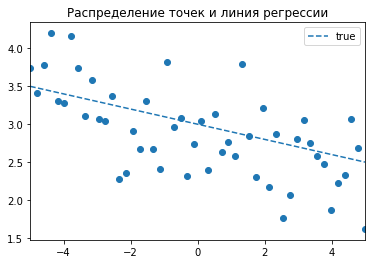

In [204]:
plt.scatter(X[:,1], y)
plt.plot(i, w0_true + w1_true * i, label='true', linestyle='dashed')
plt.xlim(x_min, x_max)
plt.legend()
plt.title("Распределение точек и линия регрессии")
plt.show()

# Решение

## 1. Линейная регрессия, МНК (Least Squares)

### 1.1 Аналитическое решение

https://en.wikipedia.org/wiki/Least_squares

$\hat{w} = (X^TX)^{-1}X^Ty$

In [205]:
w0_ls, w1_ls = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), y)

In [206]:
print(f"Коэффициенты МНК: ({w0_ls:.4f}, {w1_ls:.4f})")

Коэффициенты МНК: (2.8873, -0.1290)


### 1.2 Градиентный спуск

https://en.wikipedia.org/wiki/Gradient_descent

$w^{t+1} = w^{t} - \alpha \nabla Q (w^{t})$

$Q (w) = \frac{1}{N}  \sum_{i=1}^{N}(y_i - w x_i) ^ 2$

In [207]:
def get_sgd_coefs(X, y, alpha=None):
    np.random.seed(1)
    w0, w1 = np.random.normal(size=2)
    N = X.shape[0]
    if alpha is None:
        alpha = 1 / N
    x = X[:,1]
    for i in range(1000):
        a = w0 + w1 * x

        grad_f = 2 * (a - y)

        grad_w0 = 1/N * np.sum(grad_f)
        grad_w1 = 1/N * np.sum(grad_f * x)

        w0 = w0 - alpha * grad_w0
        w1 = w1 - alpha * grad_w1
        if np.isclose(grad_w0, 0) and np.isclose(grad_w0, 0):
            break
    return w0, w1
w0_gd, w1_gd = get_sgd_coefs(X, y)

In [208]:
print(f"Коэффициенты МНК (SGD): ({w0_gd:.4f}, {w1_gd:.4f})")

Коэффициенты МНК (SGD): (2.8873, -0.1290)


### 1.3 LinearRegression (scikit-learn)
`sklearn.linear_model.LinearRegression`

In [209]:
lr = LinearRegression(fit_intercept=False).fit(X, y)
w0_sklearn, w1_sklearn = lr.coef_

In [210]:
print(f"Коэффициенты МНК (SGD): ({w0_sklearn:.4f}, {w1_sklearn:.4f})")

Коэффициенты МНК (SGD): (2.8873, -0.1290)


In [211]:
assert np.isclose(w0_sklearn, w0_gd)
assert np.isclose(w1_sklearn, w1_gd)
assert np.isclose(w0_ls, w0_gd)
assert np.isclose(w1_ls, w1_gd)

**Все оценки совпадают**

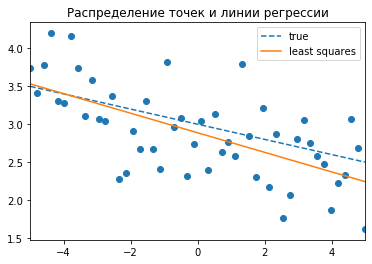

In [212]:
plt.scatter(X[:,1], y)
plt.plot(i, w0_true + w1_true * i, label='true', linestyle='dashed')
plt.plot(i, w0_ls + w1_ls * i, label='least squares')
plt.xlim(x_min, x_max)
plt.legend()
plt.title("Распределение точек и линии регрессии")
plt.show()

## 2. Байесовская регрессия

## 2.1 Аналитическое решение

https://logic.pdmi.ras.ru/~sergey/teaching/mlspsu18/04-linbayes.pdf

зависимость y:

$p(y|X, w, \sigma^2) = \prod_{i=1}^{N}N(y_i|w^Tx_i, \sigma^2)$

априорное распределение w:

$p(w) = N(w|\mu_0, \Sigma_0)$

$\mu_0 = 0$

$\Sigma_0 = \alpha^{-1}I$

апостериорное распределение w:

$p(w|y, \alpha, \sigma^2) = N(w|\mu_N, \Sigma_N)$

$\mu_N = \Sigma_N (\Sigma_0^{-1} \mu_0 + \frac{1}{\sigma^2}X^Ty)$

$\Sigma_N = (\Sigma_0^{-1} + \frac{1}{\sigma^2}X^T X)^{-1}$

In [213]:
def bayesian_update(mu, sigma, beta, x, y):
    x_matrix = np.array(x)
    sigma_n = np.linalg.inv(
        np.linalg.inv(sigma) + \
        beta * np.matmul(np.transpose(x_matrix), x_matrix)
    )
    mu_n = np.matmul(
        sigma_n,
        np.matmul(
            np.linalg.inv(sigma),
            np.transpose(mu)
        ) + beta * np.matmul(np.transpose(x_matrix), y )
    )
    sigma_x = 1 / beta + np.matmul(np.matmul(x_matrix, sigma_n), np.transpose(x_matrix))[0][0]
    return mu_n, sigma_n, sigma_x

In [224]:
alpha = 1
sigma_x = 1
beta = 1 / sigma_x ** 2

In [225]:
cur_mu, cur_sigma = np.array([0, 0]), 1 / alpha * np.array([[1, 0], [0, 1]])

In [226]:
for px, py in zip(X,y):
    cur_mu, cur_sigma, sigma_x = bayesian_update(cur_mu, cur_sigma, beta, [px], [py])

In [227]:
w0_bayes, w1_bayes = cur_mu

In [228]:
print(f"Коэффициенты МНК (SGD): ({w0_bayes:.4f}, {w1_bayes:.4f})")

Коэффициенты МНК (SGD): (2.8307, -0.1287)


### 2.2 RidgeRegression (scikit-learn)
`sklearn.linear_model.Ridge`

In [229]:
lr = Ridge(alpha=alpha / beta, fit_intercept=False).fit(X, y)
w0_ridge, w1_ridge = lr.coef_

In [230]:
w0_ridge, w1_ridge

(2.8306500464430684, -0.12869494434483367)

In [231]:
assert np.isclose(w0_ridge, w0_bayes)
assert np.isclose(w1_ridge, w1_bayes)

Достоинство байесовской регрессии - получаем распределение w и y

зависимость y:

$p(y|y_{old}, \alpha, \sigma^2) = N(y|\mu_N^TX, \sigma_N^2)$

$\sigma_N^2 = \sigma_0^2 + X^T \Sigma_N X$

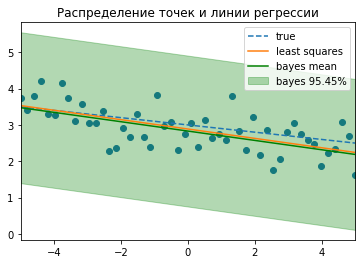

In [236]:
plt.scatter(X[:,1], y)
plt.plot(i, w0_true + w1_true * i, label='true', linestyle='dashed')
plt.plot(i, w0_ls + w1_ls * i, label='least squares')
plt.plot(i, w0_bayes + w1_bayes * i, label='bayes mean', c="g")
line = w0_bayes + w1_bayes * i
error = 2 * np.sqrt(sigma_x)
plt.fill_between(i, line - error, line + error, label="bayes 95.45%", alpha=0.3, color="g")
plt.xlim(x_min, x_max)
plt.legend()
plt.title("Распределение точек и линии регрессии")
plt.show()